# Station interpolation

Use-Case: Moving sensors -> simulate bus stop with different intervals and rest durations

Select one station that and set time interval. Interpolate missing values by regressor with training from surrounding stations.

In [89]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point, box
from matplotlib.lines import Line2D

crs = 'EPSG:3857'
crs_plot = 'EPSG:4326'

# # DWD Reference
# # 53.6332;9.9881

df = pd.read_csv('./data/netatmo/june_hamburg/hamburg_06_23_after_qc.csv', parse_dates=['time'])
qc_gdf = gpd.GeoDataFrame(df, geometry=df[[
    'lat', 'lon']].apply(lambda row: Point(row[0], row[1]), axis=1), crs=crs)

# qc_gdf = qc_gdf.to_crs(crs)
qc_gdf.drop('z', axis=1, inplace=True)

m5_gdf = qc_gdf[qc_gdf['m5'] == True]
rest_gdf = qc_gdf[qc_gdf['m5'] == False]

## Plotting QC

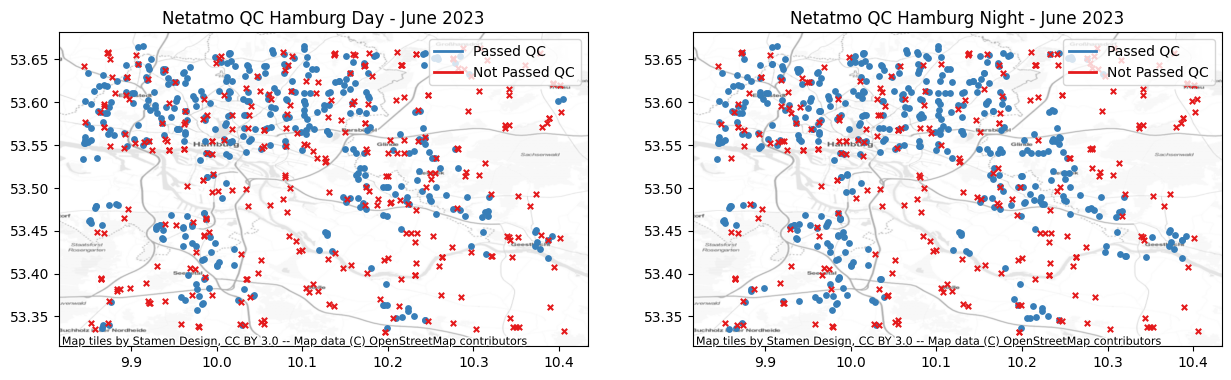

In [92]:
def plot_qc_locations(gdf1, gdf2, title, ax):
    gdf1.plot(marker='o', ax=ax, markersize=15, color='#377eb8')
    gdf2.plot(marker='x', ax=ax, markersize=15, color='#e41a1c' )

    custom_lines = [Line2D([0], [0], color='#377eb8', lw=2),
                    Line2D([0], [0], color='#e41a1c', lw=2)]

    ax.legend(handles=custom_lines, labels=['Passed QC', 'Not Passed QC'], loc='upper right')

# Set axis title and add basemap
    ax.set_title(title)
    ctx.add_basemap(
    ax,
    crs=crs_plot,
    alpha=0.7,
    source=ctx.providers.Stamen.TonerLite
)

# Plot gdf
fig, ax = plt.subplots(1, 2, figsize=(15,10))

# Filter by time because first time everything is false
m5_gdf_day = m5_gdf[m5_gdf['time'] == '2023-06-19 14:00:00']
rest_gdf_day = rest_gdf[rest_gdf['time'] == '2023-06-19 14:00:00']

plot_qc_locations(m5_gdf_day, rest_gdf_day, 'Netatmo QC Hamburg Day - June 2023', ax[0])

m5_gdf_night = m5_gdf[m5_gdf['time'] == '2023-06-19 02:00:00']
rest_gdf_night = rest_gdf[rest_gdf['time'] == '2023-06-19 02:00:00']

plot_qc_locations(m5_gdf_night, rest_gdf_night, 'Netatmo QC Hamburg Night - June 2023', ax[1])

In [93]:
# Select stations

Nienstedten = [53.552792,9.846225]
Stellingen = [53.593895,9.928416]
Fuhlsbüttel = [53.629954,10.012461]
Eimsbüttel = [53.569332,9.956562]
Eppendorf = [53.582269,9.986992]
Hafencity = [53.541312,9.988897]
Mümmelmansberg = [53.518018,10.165679]
WinsenLuhe = [53.348226,10.209836]
Emmelndorf = [53.393568,9.985493]
Harburg = [53.457814,9.971818]

# Flatten list of x y coordinates
names = ['Nienstedten', 'Stellingen', 'Fuhlsbüttel', 'Eimsbüttel', 'Eppendorf', 'Hafencity', 'Mümmelmansberg', 'WinsenLuhe', 'Emmelndorf', 'Harburg']
stations = pd.DataFrame([Nienstedten, Stellingen, Fuhlsbüttel, Eimsbüttel, Eppendorf, Hafencity, Mümmelmansberg, WinsenLuhe, Emmelndorf, Harburg])
test_locations_gdf = gpd.GeoDataFrame(names, geometry=stations.iloc[:,:].apply(lambda row: Point(row[0], row[1]), axis=1), crs=crs)

print(test_locations_gdf)

sjoin


                0               geometry
0     Nienstedten   POINT (53.553 9.846)
1      Stellingen   POINT (53.594 9.928)
2     Fuhlsbüttel  POINT (53.630 10.012)
3      Eimsbüttel   POINT (53.569 9.957)
4       Eppendorf   POINT (53.582 9.987)
5       Hafencity   POINT (53.541 9.989)
6  Mümmelmansberg  POINT (53.518 10.166)
7      WinsenLuhe  POINT (53.348 10.210)
8      Emmelndorf   POINT (53.394 9.985)
9         Harburg   POINT (53.458 9.972)


Text(0.5, 0, 'Date')

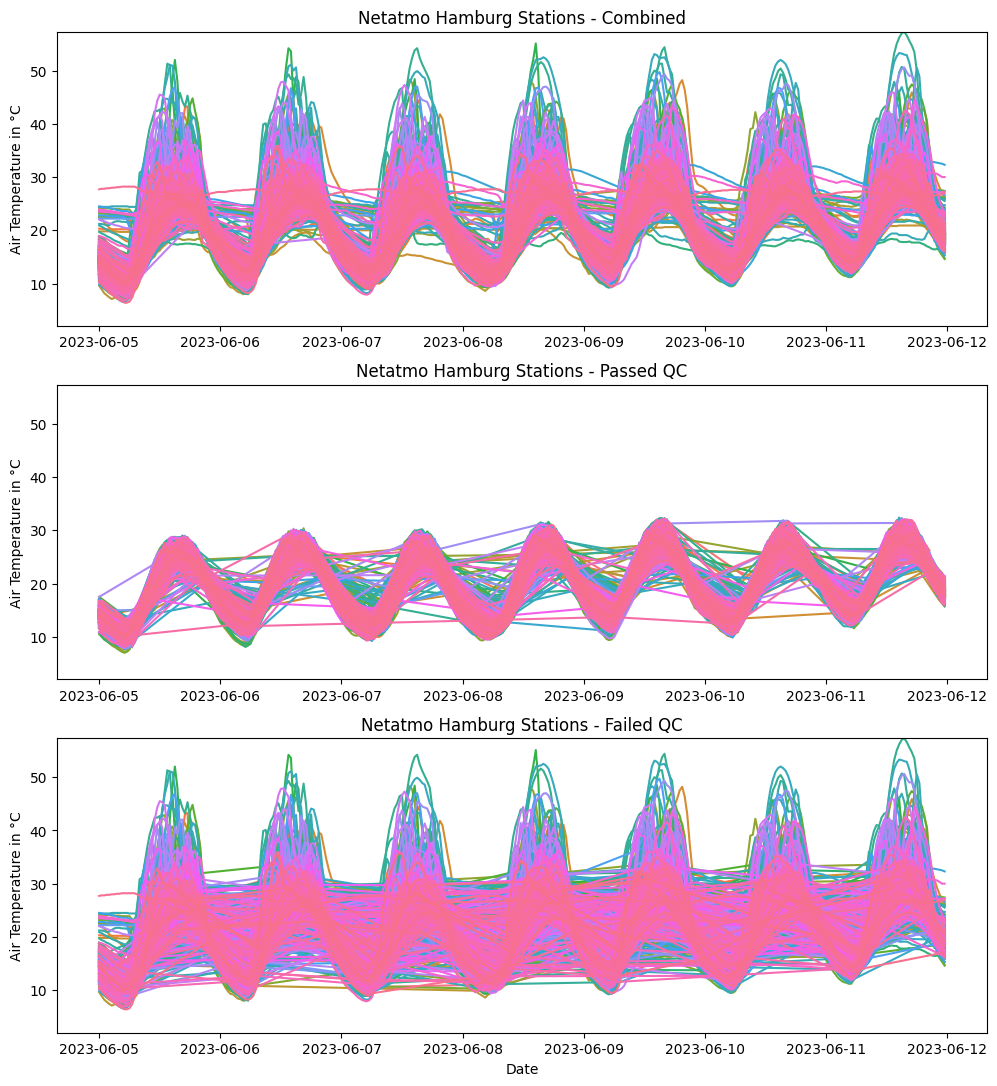

In [98]:
import seaborn as sns
import matplotlib.dates as md

# Plot lines of temperature of stations

# Plot daily_mean_temp_2m as line plot
fig, ax = plt.subplots(3, 1, figsize=(12, 13))
ymin, ymax = qc_gdf.ta.min(), qc_gdf.ta.max()

def plot_stations_ta(gdf, ax, title):
    grouped_df = gdf.groupby([pd.Grouper(key='p_id'), pd.Grouper(key="time", freq="10T")]).agg({'ta': 'first'})

    sns.lineplot(x='time', 
             y='ta',
             hue='p_id', 
             data=grouped_df,
             ax=ax,
             legend=False)
    ax.set_ylabel('Air Temperature in °C')
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel(None)
    ax.set_title(title)

plot_stations_ta(qc_gdf[(qc_gdf['time'] >= '2023-06-05') & (qc_gdf['time'] < '2023-06-12')], ax[0], 'Netatmo Hamburg Stations - Combined')
plot_stations_ta(m5_gdf[(m5_gdf['time'] >= '2023-06-05') & (m5_gdf['time'] < '2023-06-12')], ax[1], 'Netatmo Hamburg Stations - Passed QC')
plot_stations_ta(rest_gdf[(rest_gdf['time'] >= '2023-06-05') & (rest_gdf['time'] < '2023-06-12')], ax[2], 'Netatmo Hamburg Stations - Failed QC')

ax[2].set_xlabel('Date')

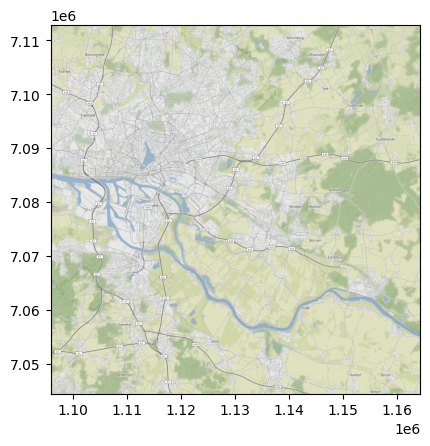

In [29]:
import seaborn as sns
import matplotlib.dates as md

# Hamburg - Location
lat, lon = 53.592580,9.924545
ymin, ymin, ymax, ymax = lon - 0.01, lat - 0.01, lon + 0.01, lat + 0.01

crs = 'EPSG:4326'

# # DWD Reference
# # 53.6332;9.9881

# lat1, lon1 = 53.65, 9.8
# lat2, lon2 = 53.53, 10.05

# # # Create a bounding box geometry
bounding_box = box(ymin, ymax, ymax, ymin)

slice_gdf = m5_gdf[m5_gdf.geometry.within(bounding_box)]

w, s, e, n = slice_gdf.to_crs(epsg=3857).total_bounds

## Dataset Creation For ML

In [39]:
from scipy.spatial import KDTree
import pandas as pd
import geopandas as gpd
from pytz import UTC

nearest_neighbors_count = 50
feature_count = 1

p_ids_df = qc_gdf.groupby('p_id').agg({'geometry': 'first'}).reset_index()
locations = list(p_ids_df['geometry'].apply(lambda x: (x.x, x.y)))

print('Building tree...')
# More build time but better query time
tree = KDTree(locations, balanced_tree=True)

def create_neighbour_df(coords):
    # Get nearest neighbors including current location, euclidean distance
    dist, idx = tree.query(coords, k=nearest_neighbors_count + 1, p=2)

    # First entry is the point itself
    idx = idx[0]
    dist = dist[0]

    # Drop Timestamp and geometry
    gdB_nearest = p_ids_df.iloc[idx]

    neighbour_ids = gdB_nearest['p_id'].reset_index(drop=True)

    neighbours_gdf = m5_gdf[m5_gdf['p_id'].isin(gdB_nearest['p_id'])]

    return neighbours_gdf, neighbour_ids

start = pd.Timestamp('2023-06-01 00:30:00', tz=UTC)
end = start + pd.Timedelta(days=30)

columns = ['y']
columns.extend(['ta_' + str(i) for i in range(1, nearest_neighbors_count + 1)])
columns.extend(['feature_' + str(i) for i in range(1, feature_count + 1)])

def create_dataset_for_sensor_id(start, end, columns, neighbours_gdf, neighbour_ids, sensor_id):
    X = pd.DataFrame(columns=columns)
    X.reset_index(drop=True, inplace=True)

    for date in pd.date_range(start=start, end=end, freq='30min'):
        start_time = date.to_datetime64()
        end_time = start_time + pd.Timedelta(minutes=30)

        filtered_gdf = neighbours_gdf.copy()
        filtered_gdf = filtered_gdf[(filtered_gdf['time'] >= start_time) & (filtered_gdf['time'] < end_time)]
        filtered_gdf.set_index('p_id', inplace=True)

        if filtered_gdf.empty:
            continue

        # Convert time to time of day
        filtered_gdf['time'] = filtered_gdf['time'].apply(lambda x: (x.hour * 60 + x.minute) * 2 * np.pi / (24 * 60))
        filtered_gdf.rename(columns={'time': 'time_angle'}, inplace=True)

        # Calculate continuous representation of time as an angle in radians
        filtered_gdf['sin_time'] = np.sin(filtered_gdf['time_angle'])
        filtered_gdf['cos_time'] = np.cos(filtered_gdf['time_angle'])

        nr_cols = nearest_neighbors_count + feature_count + 1
        x = np.empty(nr_cols, dtype=object)
        x[:] = np.nan

        for index, neighbour in neighbour_ids.items():
            if neighbour_ids[index] in filtered_gdf.index:
                x[index] = filtered_gdf.loc[neighbour_ids[index]].ta

        if x[0] is np.nan:
            continue
    
        x[-1] = filtered_gdf['sin_time'].values[0]
        x = x.reshape(1, nr_cols)

        new = pd.DataFrame(x, columns=columns)
    
        X = pd.concat([X, new], axis=0, ignore_index=True)

    if X.empty or len(X.values) < 10:
        print(f'No data for sensor {sensor_id} with {len(X.values)} entries')
        return

    X.to_csv(f'./data/testsets/{sensor_id}_dataset.csv', index=False)

p_ids_df.reset_index(drop=True, inplace=True)

for index, row in p_ids_df[0:10].iterrows():
    coords = row.geometry.coords
    neighbours_gdf, neighbour_ids = create_neighbour_df(coords)

    create_dataset_for_sensor_id(start, end, columns, neighbours_gdf, neighbour_ids, row.p_id)


Building tree...
No data for sensor 70:ee:50:00:1c:3a with 0 entries


# ML Model Eval

In [86]:
# Create test dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

eval_df = pd.DataFrame(columns=["p_id", "n_neighbours", "n_features", "MAE", "MSE", "RMSE", "R2", "actual", "predicted"])

# Test for different number of nearest neighbours
for index, row in p_ids_df[1:10].iterrows():
    sensor_id = row.p_id
    parent_df = pd.read_csv(f'./data/testsets/{sensor_id}_dataset.csv')
    nr_columns = len(df.columns) - 1 # remove index column

    for nr_neighbours in range(1, 51):
        features = parent_df.iloc[:, nr_columns:nr_columns-feature_count:-1] # Select features from the end
        neighbours = parent_df.iloc[:, 0:nr_neighbours + 1] # select neighbours from the beginning including the target value at first position

        # Select number of neighbours
        df = pd.concat([neighbours, features], axis=1)

        # Drop rows without target value
        df.dropna(subset=['y'], inplace=True)

        # Drop rows with all NaN values
        # df.dropna(how='all', inplace=True)

        X = df.drop(['y'], axis=1)
        y = df.y.values

        if X.empty:
            print(f'Empty dataset for {sensor_id} and neighbour count {nr_neighbours}')
            continue

        if len(X.values) < 5:
            print(f'Not enough data for {sensor_id} and neighbour count {nr_neighbours} with {len(X.values)} rows')
            continue

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=1, shuffle=True)

        ## KNN
        normalize = True

        X_train_norm = X_train
        X_test_norm = X_test

        if normalize:
            scaler_X = StandardScaler().fit(X_train)
            X_train_norm = scaler_X.transform(X_train)
            X_test_norm = scaler_X.transform(X_test)

        regr = HistGradientBoostingRegressor(max_iter=200, random_state=42)
        regr.fit(X_train_norm, y_train)
        y_pred = regr.predict(X_test_norm)

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        # Evaluation
        # Write results into df
        new = pd.DataFrame({
            "p_id": sensor_id,
            "n_neighbours": nr_neighbours,
            "n_features": feature_count,
            "MAE": mean_absolute_error(y_test, y_pred),
            "MSE": mean_squared_error(y_test, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
            "R2": r2_score(y_test, y_pred),
            "actual": y_test[0],
            "predicted": y_pred[0]
            }, index=[0])

        eval_df = pd.concat([eval_df.loc[:], new]).reset_index(drop=True)

print(eval_df)

/Users/ian/Repos/uni/sensor-data-ml/venv/lib/python3.8/site-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/ian/Repos/uni/sensor-data-ml/venv/lib/python3.8/site-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/ian/Repos/uni/sensor-data-ml/venv/lib/python3.8/site-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/Users/ian/Repos/uni/sensor-data-ml/venv/lib/python3.8/site-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/ian/Repos/uni/sensor-data-ml/venv/lib/python3.8/site-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_s

                  p_id n_neighbours n_features       MAE       MSE      RMSE  \
0    70:ee:50:00:1e:4c            1          1  0.996856  2.746663  1.657306   
1    70:ee:50:00:1e:4c            2          1  0.804147  1.966769  1.402415   
2    70:ee:50:00:1e:4c            3          1  0.383944  0.316664  0.562729   
3    70:ee:50:00:1e:4c            4          1  0.360890  0.302349  0.549863   
4    70:ee:50:00:1e:4c            5          1  0.343080  0.246568  0.496556   
..                 ...          ...        ...       ...       ...       ...   
445  70:ee:50:00:b4:9a           46          1  0.280830  0.183660  0.428556   
446  70:ee:50:00:b4:9a           47          1  0.280830  0.183660  0.428556   
447  70:ee:50:00:b4:9a           48          1  0.280830  0.183660  0.428556   
448  70:ee:50:00:b4:9a           49          1  0.280830  0.183660  0.428556   
449  70:ee:50:00:b4:9a           50          1  0.280830  0.183660  0.428556   

           R2  actual  predicted  
0   

In [71]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(eval_df)

                  p_id n_neighbours n_features       mae        mse      rmse  \
0    70:ee:50:00:1e:4c            1          1  1.231266   4.469619  2.114147   
1    70:ee:50:00:1e:4c            2          1  1.231266   4.469619  2.114147   
2    70:ee:50:00:1e:4c            3          1  0.445319   0.423969  0.651129   
3    70:ee:50:00:1e:4c            4          1  0.404909   0.375785  0.613013   
4    70:ee:50:00:1e:4c            5          1  0.390540   0.318869  0.564685   
5    70:ee:50:00:1e:4c            6          1  0.363925   0.269276  0.518918   
6    70:ee:50:00:1e:4c            7          1  0.353576   0.251989  0.501985   
7    70:ee:50:00:1e:4c            8          1  0.331566   0.227973  0.477465   
8    70:ee:50:00:1e:4c            9          1  0.312325   0.211602  0.460002   
9    70:ee:50:00:1e:4c           10          1  0.310871   0.219594  0.468609   
10   70:ee:50:00:1e:4c           11          1  0.288407   0.186675  0.432059   
11   70:ee:50:00:1e:4c      

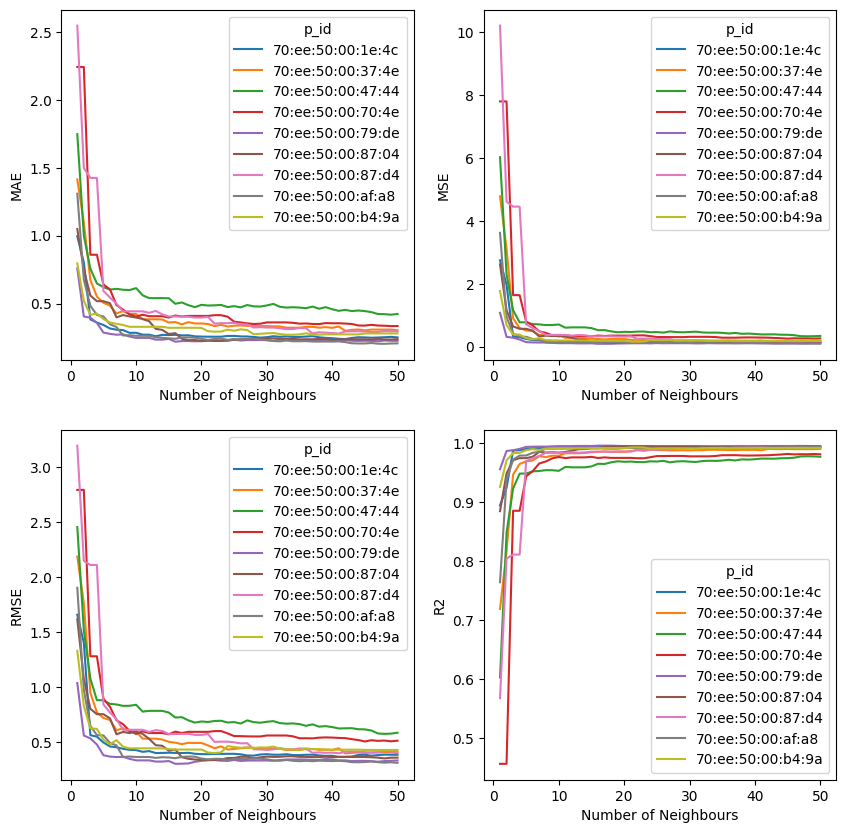

In [88]:
import seaborn as sns

# Define the color palette for the lines
color_palette = sns.color_palette('tab10')  # You can choose other palettes or define custom colors

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

grouped_df = eval_df

# Set the 'hue' parameter in each lineplot call to differentiate the lines based on the 'hue' value
sns.lineplot(data=grouped_df, x='n_neighbours', y='MAE', ax=axs[0][0], hue="p_id", legend='auto', color=color_palette)
sns.lineplot(data=grouped_df, x='n_neighbours', y='MSE', ax=axs[0][1], hue="p_id", legend='auto', color=color_palette)
sns.lineplot(data=grouped_df, x='n_neighbours', y='RMSE', ax=axs[1][0], hue="p_id", legend='auto', color=color_palette)
sns.lineplot(data=grouped_df, x='n_neighbours', y='R2', ax=axs[1][1], hue="p_id", legend='auto', color=color_palette)

# axs[0].set_title('Mean Absolute Error')
axs[0][0].set_xlabel('Number of Neighbours')
axs[0][1].set_xlabel('Number of Neighbours')
axs[1][0].set_xlabel('Number of Neighbours')
axs[1][1].set_xlabel('Number of Neighbours')
# axs[0].set_ylabel('MAE')

plt.show()